# **Unidentified Flying Analytics:**
---
### Project Overview

What can we say about UFO sightings?  

**Questions**:
- What areas of the country are most likely to have UFO sightings? 
- Are there any trends in UFO sightings over time? 
- Do clusters of UFO sightings correlate with landmarks, such as airports or military bases? 
- What are the most common UFO descriptions?
- Do UFO sightings correlate with bigfoot sightings
- Sightings per capita

---
### Datasets
- UFO sightings
https://www.kaggle.com/NUFORC/ufo-sightings
- Bigfoot sightings
https://data.world/timothyrenner/bfro-sightings-data
- Airport locations
https://ourairports.com/countries/US/
- Military bases
https://public.opendatasoft.com/explore/dataset/military-bases/table/
- Population
https://www.census.gov/newsroom/press-kits/2019/national-state-estimates.html




### Import dependencies

In [2]:
!pip install plotly

In [1]:
import pandas as pd
import requests
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import *
import zipfile
import geopandas as gpd
import glob
import plotly.express as px

### Get UFO sightings file

In [53]:
file_path = 'https://raw.githubusercontent.com/kflemming30/UFO_sightings/main/original_scrubbed.csv'
ufo_data = pd.read_csv(file_path)
ufo_data.head()

C:\Users\12039\AppData\Local\Temp\ipykernel_57304\3906742557.py:2: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  ufo_data = pd.read_csv(file_path)


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [34]:
ufo_data.dtypes

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                 object
longitude               float64
dtype: object

### Clean UFO sightings file

In [54]:
# Identify rows with problematic datetime values
problematic_dates = ufo_data['datetime'].loc[ufo_data['datetime'].str.contains('24:00')]
# Display rows with problematic datetime values after replacement
print(problematic_dates)

388      10/11/2006 24:00
693       10/1/2001 24:00
962       10/1/2012 24:00
1067     10/12/2003 24:00
1221     10/12/2013 24:00
               ...       
79136      9/4/2005 24:00
79137      9/4/2005 24:00
79740      9/7/2002 24:00
79759      9/7/2004 24:00
79942      9/8/2003 24:00
Name: datetime, Length: 694, dtype: object


In [55]:
# Replace the problematic values with an appropriate hour
ufo_data['datetime'] = ufo_data['datetime'].str.replace('24:00', '00:00')
# Convert the column to datetime
ufo_data['datetime'] = pd.to_datetime(ufo_data['datetime'], errors='coerce')

In [56]:
ufo_data['date posted'] = pd.to_datetime(ufo_data['date posted'])

In [57]:
ufo_data['duration (seconds)'] = pd.to_numeric(ufo_data['duration (seconds)'], errors='coerce')

In [58]:
ufo_data['duration(minutes)'] = ufo_data['duration (seconds)']/60

In [59]:
ufo_data['latitude'] = pd.to_numeric(ufo_data['latitude'], errors='coerce')

In [60]:
ufo_data.dtypes

datetime                datetime64[ns]
city                            object
state                           object
country                         object
shape                           object
duration (seconds)             float64
duration (hours/min)            object
comments                        object
date posted             datetime64[ns]
latitude                       float64
longitude                      float64
duration(minutes)              float64
dtype: object

In [61]:
ufo_data['shape'].unique()

array(['cylinder', 'light', 'circle', 'sphere', 'disk', 'fireball',
       'unknown', 'oval', 'other', 'cigar', 'rectangle', 'chevron',
       'triangle', 'formation', nan, 'delta', 'changing', 'egg',
       'diamond', 'flash', 'teardrop', 'cone', 'cross', 'pyramid',
       'round', 'crescent', 'flare', 'hexagon', 'dome', 'changed'],
      dtype=object)

In [43]:
ufo_data['country'].unique()

array(['us', nan, 'gb', 'ca', 'au', 'de'], dtype=object)

In [44]:
ufo_data['city'].unique()

array(['san marcos', 'lackland afb', 'chester (uk/england)', ...,
       'calmar (canada)', 'aleksandrow (poland)', 'hamstead (hollyridge)'],
      dtype=object)

In [45]:
ufo_data['state'].unique()

array(['tx', nan, 'hi', 'tn', 'ct', 'al', 'fl', 'ca', 'nc', 'ny', 'ky',
       'mi', 'ma', 'ks', 'sc', 'wa', 'ab', 'co', 'nh', 'wi', 'me', 'ga',
       'pa', 'il', 'ar', 'on', 'mo', 'oh', 'in', 'az', 'mn', 'nv', 'nf',
       'ne', 'or', 'bc', 'ia', 'va', 'id', 'nm', 'nj', 'mb', 'wv', 'ok',
       'ri', 'nb', 'vt', 'la', 'pr', 'ak', 'ms', 'ut', 'md', 'mt', 'sk',
       'wy', 'sd', 'pq', 'ns', 'qc', 'de', 'nd', 'dc', 'nt', 'sa', 'yt',
       'yk', 'pe'], dtype=object)

In [62]:
ufo_data['state'] = ufo_data['state'].str.upper()

In [63]:
ufo_data_cleaned['state'].unique()

array(['TX', nan, 'HI', 'TN', 'CT', 'AL', 'FL', 'CA', 'NC', 'NY', 'KY',
       'MI', 'MA', 'KS', 'SC', 'WA', 'AB', 'CO', 'NH', 'WI', 'ME', 'GA',
       'PA', 'IL', 'AR', 'ON', 'MO', 'OH', 'IN', 'AZ', 'MN', 'NV', 'NF',
       'NE', 'OR', 'BC', 'IA', 'VA', 'ID', 'NM', 'NJ', 'MB', 'WV', 'OK',
       'RI', 'NB', 'VT', 'LA', 'PR', 'AK', 'MS', 'UT', 'MD', 'MT', 'SK',
       'WY', 'SD', 'PQ', 'NS', 'QC', 'DE', 'ND', 'DC', 'NT', 'SA', 'YT',
       'YK', 'PE'], dtype=object)

In [65]:
# Convert 'date posted' to datetime
ufo_data['datetime'] = pd.to_datetime(ufo_data['datetime'])

# Extract year from the timestamp column
ufo_data['year'] = ufo_data['datetime'].dt.year

In [66]:
year_counts = ufo_data['year'].value_counts()
year_counts

2012    7357
2013    7037
2011    5107
2008    4820
2009    4541
        ... 
1920       1
1916       1
1906       1
1925       1
1934       1
Name: year, Length: 87, dtype: int64

In [67]:
ufo_data.to_csv('ufo_data_cleaned.csv', index=False)

In [68]:
ufo_data_cleaned = pd.read_csv('https://raw.githubusercontent.com/kflemming30/UFO_sightings/main/ufo_data_cleaned.csv')

In [69]:
ufo_data_cleaned.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,duration(minutes),year
0,1949-10-10 20:30:00,san marcos,TX,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,2004-04-27,29.883056,-97.941111,45.000000,1949
1,1949-10-10 21:00:00,lackland afb,TX,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082,120.000000,1949
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,0.333333,1955
3,1956-10-10 21:00:00,edna,TX,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.978333,-96.645833,0.333333,1956
4,1960-10-10 20:00:00,kaneohe,HI,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22,21.418056,-157.803611,15.000000,1960


In [70]:
(ufo_data_cleaned.isnull().mean() * 100).round(2)

datetime                 0.00
city                     0.00
state                    7.22
country                 12.04
shape                    2.41
duration (seconds)       0.00
duration (hours/min)     0.00
comments                 0.02
date posted              0.00
latitude                 0.00
longitude                0.00
duration(minutes)        0.00
year                     0.00
dtype: float64

In [71]:
ufo_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80329 non-null  float64
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80331 non-null  float64
 10  longitude             80332 non-null  float64
 11  duration(minutes)     80329 non-null  float64
 12  year                  80332 non-null  int64  
dtypes: float64(4), int64(1), object(8)
memory usage: 8.0+ MB


## Pull in other datasets

### Pull in population by state

In [117]:
population_by_state = pd.read_csv("C:\\Users\\12039\\Documents\\UFO_sightings\\population_by_state.csv")
population_by_state.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2014,POPEST18PLUS2014,PCNT_POPEST18PLUS
0,10,0,0,0,United States,318857056,245273438,76.9
1,40,3,6,1,Alabama,4849377,3741806,77.2
2,40,4,9,2,Alaska,736732,550189,74.7
3,40,4,8,4,Arizona,6731484,5109792,75.9
4,40,3,7,5,Arkansas,2966369,2259350,76.2


In [118]:
population_by_state = population_by_state[population_by_state['NAME'] != 'United States']
population_by_state.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2014,POPEST18PLUS2014,PCNT_POPEST18PLUS
1,40,3,6,1,Alabama,4849377,3741806,77.2
2,40,4,9,2,Alaska,736732,550189,74.7
3,40,4,8,4,Arizona,6731484,5109792,75.9
4,40,3,7,5,Arkansas,2966369,2259350,76.2
5,40,4,9,6,California,38802500,29649348,76.4


In [119]:
population_by_state = population_by_state[['NAME', 'POPESTIMATE2014']]
population_by_state = population_by_state.rename(columns={'NAME': 'STATE'})
population_by_state.head()

,STATE,POPESTIMATE2014
1,Alabama,4849377
2,Alaska,736732
3,Arizona,6731484
4,Arkansas,2966369
5,California,38802500


In [76]:
population_by_state['STATE'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming',
       'Puerto Rico Commonwealth'], dtype=object)

## Where are sightings most likely?

### Create state_counts of sightings

In [ ]:
us_sightings = ufo_data_cleaned[ufo_data_cleaned['country'] == 'us']
state_counts = us_sightings.groupby('state').size().reset_index(name='sightings_count').sort_values(by='sightings_count', ascending = False)
print(state_counts)

### Create mapping dictionary for state name and abbreviation

In [78]:
state_abbr_mapping = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}


### Add state population to state_counts

In [120]:
# Map state abbreviations to state names using the state_abbr_mapping
state_counts['STATE'] = state_counts['state'].map(state_abbr_mapping)

# Merge the us_sightings DataFrame with population_by_state based on the 'STATE' column
merged_df = pd.merge(state_counts, population_by_state[['STATE', 'POPESTIMATE2014']], on='STATE', how='left')

# Display the merged DataFrame
merged_df = merged_df.rename(columns={'STATE': 'state_long', 'POPESTIMATE2014':'pop_2014'})
merged_df['sightings_per_10k'] = (merged_df['sightings_count'] / merged_df['pop_2014']) * 10000
merged_df.sort_values(by='sightings_per_10k', ascending=False)

,state,sightings_count,state_long,pop_2014,sightings_per_10k
1,WA,3966,Washington,7061530.0,5.616347
38,MT,478,Montana,1023579.0,4.669889
10,OR,1747,Oregon,3970239.0,4.400239
42,AK,319,Alaska,736732.0,4.329933
34,ME,558,Maine,1330089.0,4.195208
44,VT,260,Vermont,626562.0,4.149629
37,NH,486,New Hampshire,1326813.0,3.662913
6,AZ,2414,Arizona,6731484.0,3.586133
28,NM,720,New Mexico,2085572.0,3.452290
36,ID,521,Idaho,1634464.0,3.187589


In [128]:
#remove listings with na
merged_df.dropna(inplace=True)
merged_df.sort_values(by='sightings_per_10k', ascending=False)

,state,sightings_count,state_long,pop_2014,sightings_per_10k
1,WA,3966,Washington,7061530.0,5.616347
38,MT,478,Montana,1023579.0,4.669889
10,OR,1747,Oregon,3970239.0,4.400239
42,AK,319,Alaska,736732.0,4.329933
34,ME,558,Maine,1330089.0,4.195208
44,VT,260,Vermont,626562.0,4.149629
37,NH,486,New Hampshire,1326813.0,3.662913
6,AZ,2414,Arizona,6731484.0,3.586133
28,NM,720,New Mexico,2085572.0,3.452290
36,ID,521,Idaho,1634464.0,3.187589


In [ ]:
#Add bigfoot sightings to df

In [130]:
merged_df.to_csv('state_totals.csv', index=False)

## Add state population to ufo_data_cleaned dataframe

In [93]:
state_abbr_mapping = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
    'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
    'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico',
    'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Create a new column 'ST' in population_by_state DataFrame using the mapping
population_by_state['ST'] = population_by_state['STATE'].map({v: k for k, v in state_abbr_mapping.items()})


In [94]:
population_by_state.head()

,STATE,POPESTIMATE2014,ST
1,Alabama,4849377,AL
2,Alaska,736732,AK
3,Arizona,6731484,AZ
4,Arkansas,2966369,AR
5,California,38802500,CA


In [95]:
# Merge ufo_data_cleaned with population_by_state based on 'state' and 'ST' columns
ufo_data_cleaned = ufo_data_cleaned.merge(population_by_state, left_on='state', right_on='ST', how='left')

# Drop the 'ST' column if needed
ufo_data_cleaned.drop('ST', axis=1, inplace=True)

ufo_data_cleaned.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,duration(minutes),year,STATE,POPESTIMATE2014
0,1949-10-10 20:30:00,san marcos,TX,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,2004-04-27,29.883056,-97.941111,45.000000,1949,Texas,26956958.0
1,1949-10-10 21:00:00,lackland afb,TX,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082,120.000000,1949,Texas,26956958.0
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,0.333333,1955,District of Columbia,658893.0
3,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,0.333333,1955,Puerto Rico Commonwealth,3548397.0
4,1956-10-10 21:00:00,edna,TX,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.978333,-96.645833,0.333333,1956,Texas,26956958.0


In [97]:
ufo_data_cleaned.to_csv('ufo_data_cleaned.csv', index=False)

## Predict sightings by other measures?

In [ ]:
ufo_data_cleaned.head()

### Bigfoot Locations

In [99]:
bigfoot_locations = pd.read_csv("https://raw.githubusercontent.com/kflemming30/UFO_sightings/main/bfro_locations.csv")
bigfoot_locations.head()

,number,title,classification,timestamp,latitude,longitude
0,637,Report 637: Campers' encounter just after dark...,Class A,2000-06-16T12:00:00Z,61.5000,-142.9000
1,2917,Report 2917: Family observes large biped from car,Class A,1995-05-15T12:00:00Z,55.1872,-132.7982
2,7963,Report 7963: Sasquatch walks past window of ho...,Class A,2004-02-09T12:00:00Z,55.2035,-132.8202
3,9317,"Report 9317: Driver on Alcan Highway has noon,...",Class A,2004-06-18T12:00:00Z,62.9375,-141.5667
4,13038,Report 13038: Snowmobiler has encounter in dee...,Class A,2004-02-15T12:00:00Z,61.0595,-149.7853


In [100]:
bigfoot_locations.dtypes

number              int64
title              object
classification     object
timestamp          object
latitude          float64
longitude         float64
dtype: object

In [101]:
bigfoot_locations['timestamp'] = pd.to_datetime(bigfoot_locations['timestamp'])
# Extract year from the timestamp column
bigfoot_locations['year'] = bigfoot_locations['timestamp'].dt.year

In [42]:
bigfoot_locations.dtypes

number                          int64
title                          object
classification                 object
timestamp         datetime64[ns, UTC]
latitude                      float64
longitude                     float64
year                            int64
dtype: object

In [ ]:
# Find unique years
unique_years = sorted(bigfoot_locations['year'].unique(), reverse=True)
unique_years

In [ ]:
from geopy.geocoders import Nominatim
import pandas as pd

# Initialize Nominatim geocoder
geolocator = Nominatim(user_agent="geoapiExercises")

def get_state(row):
    """Get state from latitude and longitude"""
    location = geolocator.reverse(f"{row['latitude']}, {row['longitude']}")
    address = location.raw['address']
    state = address.get('state', '')
    return state

# Apply function to create 'state' column
bigfoot_locations['state'] = bigfoot_locations.apply(get_state, axis=1)

bigfoot_locations.head()


In [ ]:
#add state column
import requests
import pandas as pd

API_KEY = 'enter here'

def get_location_info(row):
    """Geocode the lat/lon using Google Maps API and return the state."""
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    lat, lon = row['latitude'], row['longitude']
    
    params = {
        "latlng": f"{lat},{lon}",
        "key": API_KEY
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    # Extracting the state from the API response
    state = None
    if data['results']:
        address_components = data['results'][0]['address_components']
        for component in address_components:
            if 'administrative_area_level_1' in component['types']:
                state = component['short_name']
                break

    return state

# Applying the function to create the 'state' column
bigfoot_locations['state'] = bigfoot_locations.apply(get_location_info, axis=1)

# Displaying the resulting DataFrame with the added 'state' column
bigfoot_locations.head()


## Create df by state with ufo sightings and bigfoot sightings

In [104]:
# Group by 'state' and perform aggregations
state_sightings = ufo_data_cleaned[ufo_data_cleaned['country'] == 'us'].groupby('state').agg({
    'duration (seconds)': 'mean',
    'duration(minutes)': 'mean',
    'year': 'count'
})

# Rename the columns for clarity
state_sightings.rename(columns={
    'duration (seconds)': 'mean_duration_seconds',
    'duration(minutes)': 'mean_duration_minutes',
    'year': 'ufo_sightings'
}, inplace=True)

# Reset the index to make 'state' a regular column instead of the index
state_sightings.reset_index(inplace=True)
state_sightings.head()

,state,mean_duration_seconds,mean_duration_minutes,ufo_sightings_since_2010
0,AK,4615.752351,76.929206,319
1,AL,1411.538162,23.525636,642
2,AR,113930.296769,1898.838279,588
3,AZ,6425.574637,107.092911,2414
4,CA,3381.238298,56.353972,8912


In [105]:
import pandas as pd

# Escape the backslashes in the file path
file_path = "C:\\Users\\12039\\Documents\\UFO_sightings\\bfro_reports_geocoded.csv"
bigfoot_sightings = pd.read_csv(file_path)

In [106]:
bigfoot_sightings.head()

,observed,location_details,county,state,season,title,latitude,longitude,date,number,...,precip_intensity,precip_probability,precip_type,pressure,summary,conditions,uv_index,visibility,wind_bearing,wind_speed
0,I am not sure how relevant this report will be...,"We were on our way to Rapid City, so we were h...",Washakie County,Wyoming,Summer,NaN,NaN,NaN,NaN,798.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I don't know if what I saw was two bigfoots or...,"Heading to the deep mine Poca #2, the airshaft...",Wyoming County,West Virginia,Winter,Report 13237: Daylight sighting near an abando...,37.58135,-81.29745,2005-12-03,13237.0,...,0.204,100.0,"['rain', 'snow']",1018.7,Partly cloudy throughout the day with late aft...,"Snow, Rain, Partially cloudy",NaN,9.3,168.1,17.1
2,"My family and I went to Ludlow, Vermont for Co...",It's off Rt 100 outside of Ludlow Vermont. It ...,Windsor County,Vermont,Fall,Report 13285: Evening sighting by motorists on...,43.46540,-72.70510,2005-10-08,13285.0,...,3.208,100.0,['rain'],1011.8,Cloudy skies throughout the day with a chance ...,"Rain, Overcast",NaN,5.0,356.2,7.6
3,It was spring break 1984 and I was 16 at the t...,"Wythe county Virginia near Wytheville, looking...",Wythe County,Virginia,Spring,"Report 2285: Boy sees ""Bigfoot"" in the woods w...",37.22647,-81.09017,1984-04-08,2285.0,...,0.000,0.0,NaN,1020.9,Partly cloudy throughout the day.,Partially cloudy,NaN,13.0,107.3,11.5
4,It was the winter of 1996 and we were on our w...,"Hwy 182, Wood County Between Quitman, Texas an...",Wood County,Texas,Winter,Report 2048: Night time road crossing observation,32.79430,-95.54250,1996-12-22,2048.0,...,NaN,0.0,NaN,NaN,Partly cloudy throughout the day.,Partially cloudy,NaN,10.5,180.4,20.8


In [115]:
bigfoot_sightings.to_csv('bigfoot_sightings.csv', index=False)

In [111]:
bigfoot_sightings.columns

Index(['observed', 'location_details', 'county', 'state', 'season', 'title',
       'latitude', 'longitude', 'date', 'number', 'classification', 'geohash',
       'temperature_high', 'temperature_mid', 'temperature_low', 'dew_point',
       'humidity', 'cloud_cover', 'moon_phase', 'precip_intensity',
       'precip_probability', 'precip_type', 'pressure', 'summary',
       'conditions', 'uv_index', 'visibility', 'wind_bearing', 'wind_speed'],
      dtype='object')

In [113]:
bigfoot_sightings['date'] = pd.to_datetime(bigfoot_sightings['date'])

In [125]:
bigfoot_sightings.dtypes

observed                      object
location_details              object
county                        object
state                         object
season                        object
title                         object
latitude                     float64
longitude                    float64
date                  datetime64[ns]
number                       float64
classification                object
geohash                       object
temperature_high             float64
temperature_mid              float64
temperature_low              float64
dew_point                    float64
humidity                     float64
cloud_cover                  float64
moon_phase                   float64
precip_intensity             float64
precip_probability           float64
precip_type                   object
pressure                     float64
summary                       object
conditions                    object
uv_index                     float64
visibility                   float64
w

In [135]:
state_totals = pd.read_csv('https://raw.githubusercontent.com/kflemming30/UFO_sightings/main/state_totals.csv')
state_totals.head()

,state,sightings_count,state_long,pop_2014,sightings_per_10k
0,CA,8912,California,38802500.0,2.296759
1,WA,3966,Washington,7061530.0,5.616347
2,FL,3835,Florida,19893297.0,1.927785
3,TX,3447,Texas,26956958.0,1.278705
4,NY,2980,New York,19746227.0,1.509149


In [139]:
state_bf_counts = bigfoot_sightings.groupby('state').size().reset_index(name='count')
state_bf_counts.head()

,state,count
0,Alabama,95
1,Alaska,21
2,Arizona,85
3,Arkansas,103
4,California,422


In [141]:
# Merge state_totals with state_bf_counts based on 'state_long' and 'state' columns
ufo_bf_state_totals = state_totals.merge(state_bf_counts, left_on='state_long', right_on='state', how='left')

# Drop the 'state_y' column
ufo_bf_state_totals.drop('state_y', axis=1, inplace=True)

# Rename the 'state_x' column to 'state'
ufo_bf_state_totals.rename(columns={'state_x': 'state'}, inplace=True)

# Display the resulting DataFrame
ufo_bf_state_totals.head()

,state,sightings_count,state_long,pop_2014,sightings_per_10k,count
0,CA,8912,California,38802500.0,2.296759,422.0
1,WA,3966,Washington,7061530.0,5.616347,610.0
2,FL,3835,Florida,19893297.0,1.927785,306.0
3,TX,3447,Texas,26956958.0,1.278705,231.0
4,NY,2980,New York,19746227.0,1.509149,114.0


In [143]:
ufo_bf_state_totals.to_csv('ufo_bf_state_totals.csv', index=False)

In [144]:
ufo_bf_state_totals.head()

,state,sightings_count,state_long,pop_2014,sightings_per_10k,count
0,CA,8912,California,38802500.0,2.296759,422.0
1,WA,3966,Washington,7061530.0,5.616347,610.0
2,FL,3835,Florida,19893297.0,1.927785,306.0
3,TX,3447,Texas,26956958.0,1.278705,231.0
4,NY,2980,New York,19746227.0,1.509149,114.0


In [159]:
ufo_bf_state_totals['bf_sightings_per_10k'] = (ufo_bf_state_totals['bf_sightings'] / ufo_bf_state_totals['population']) * 10000

In [160]:
ufo_bf_state_totals.rename(columns={'count': 'bf_sightings', 'pop_2014': 'population','sightings_count': 'ufo_sightings' ,'sightings_per_10k': 'ufo_sightings_per_10k'}, inplace=True)
ufo_bf_state_totals.head()

,state,ufo_sightings,state_long,population,ufo_sightings_per_10k,bf_sightings,bf_sightings_per_10k
0,CA,8912,California,38802500.0,2.296759,422.0,0.108756
1,WA,3966,Washington,7061530.0,5.616347,610.0,0.863835
2,FL,3835,Florida,19893297.0,1.927785,306.0,0.153821
3,TX,3447,Texas,26956958.0,1.278705,231.0,0.085692
4,NY,2980,New York,19746227.0,1.509149,114.0,0.057733


In [147]:
ufo_bf_state_totals.to_csv('ufo_bf_state_totals.csv', index=False)

In [161]:
ufo_bf_state_totals.dtypes

state                     object
ufo_sightings              int64
state_long                object
population               float64
ufo_sightings_per_10k    float64
bf_sightings             float64
bf_sightings_per_10k     float64
dtype: object

In [157]:
correlation = ufo_bf_state_totals['ufo_sightings'].corr(ufo_bf_state_totals['bf_sightings'])
print(f"Correlation between UFO sightings and Bigfoot sightings: {correlation}")


Correlation between UFO sightings and Bigfoot sightings: 0.7875751304515509


In [162]:
correlation = ufo_bf_state_totals['ufo_sightings_per_10k'].corr(ufo_bf_state_totals['bf_sightings_per_10k'])
print(f"Correlation between UFO sightings and Bigfoot sightings: {correlation}")

Correlation between UFO sightings and Bigfoot sightings: 0.6261259995363476


In [155]:
from sklearn.impute import SimpleImputer

# Assuming 'ufo_bf_state_totals' is your DataFrame
# Drop rows with NaN values in the target column 'ufo_sightings'
ufo_bf_state_totals.dropna(subset=['ufo_sightings'], inplace=True)

# Selecting predictors (independent variables) and the target variable
X = ufo_bf_state_totals.drop(columns=['ufo_sightings','state', 'state_long'])
y = ufo_bf_state_totals['ufo_sightings']

# Impute NaN values in predictors with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
predictions = model.predict(X_test)

# Calculating the model's accuracy (using Mean Squared Error for simplicity)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 29652.42331563499


In [3]:
ufo_data_cleaned = pd.read_csv('https://raw.githubusercontent.com/kflemming30/UFO_sightings/main/ufo_data_cleaned.csv')
ufo_data_cleaned.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,duration(minutes),year,STATE,POPESTIMATE2014
0,1949-10-10 20:30:00,san marcos,TX,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,2004-04-27,29.883056,-97.941111,45.000000,1949,Texas,26956958.0
1,1949-10-10 21:00:00,lackland afb,TX,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082,120.000000,1949,Texas,26956958.0
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,0.333333,1955,District of Columbia,658893.0
3,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,0.333333,1955,Puerto Rico Commonwealth,3548397.0
4,1956-10-10 21:00:00,edna,TX,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.978333,-96.645833,0.333333,1956,Texas,26956958.0


## Correlation between state and number of sightings

In [12]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/kflemming30/UFO_sightings/main/ufo_bf_state_totals.csv')

# One-hot encode the 'state' column
one_hot_encoded = pd.get_dummies(df['state_long'])

# Concatenate the one-hot encoded columns with the 'ufo_sightings' column
merged = pd.concat([one_hot_encoded, df['ufo_sightings']], axis=1)

# Calculate the correlation
correlation = merged.corr()

# Extract the correlation between 'state' and 'ufo_sightings'
state_correlation = correlation['ufo_sightings'].drop('ufo_sightings')

print(state_correlation)


Alabama          -0.065569
Alaska           -0.097676
Arizona           0.110570
Arkansas         -0.070937
California        0.756480
Colorado          0.011069
Connecticut      -0.040719
Delaware         -0.112884
Florida           0.251819
Georgia          -0.004636
Hawaii           -0.103342
Idaho            -0.077597
Illinois          0.119019
Indiana          -0.001356
Iowa             -0.061991
Kansas           -0.068452
Kentucky         -0.044397
Louisiana        -0.073919
Maine            -0.073919
Maryland         -0.046186
Massachusetts    -0.004537
Michigan          0.053116
Minnesota        -0.028791
Mississippi      -0.092109
Missouri          0.015542
Montana          -0.081871
Nebraska         -0.091513
Nevada           -0.049566
New Hampshire    -0.081076
New Jersey       -0.004636
New Mexico       -0.057816
New York          0.166831
North Carolina    0.043574
North Dakota     -0.116562
Ohio              0.096753
Oklahoma         -0.057418
Oregon            0.044269
P

In [13]:
# Set a threshold for significant correlations
threshold = 0.5

# Filter correlations above or below the threshold
significant_correlations = state_correlation[
    (state_correlation > threshold) | (state_correlation < -threshold)
]

print("Significant correlations:")
print(significant_correlations)

Significant correlations:
California    0.75648
Name: ufo_sightings, dtype: float64


## Camping

In [14]:
camping = pd.read_csv(r"C:\Users\12039\Documents\UFO_sightings\Camping 2020 - Sheet1.csv")
camping.head()

,Rank,State,Percentage change in camping reservations (2015–2020),Total increase in camping reservations (2015–2020),Total camping reservations (2020),Most popular destination
0,1,Indiana,481.30%,"7,566","9,138",Indiana Dunes National Park
1,2,Nevada,366.30%,"15,681","19,962",Humboldt-Toiyabe National Forest
2,3,South Dakota,291.70%,"16,051","21,554",Black Hills National Forest
3,4,Michigan,229.10%,"36,312","52,165",Hiawatha National Forest
4,5,Wyoming,147.40%,"13,798","23,158",Bighorn National Forest


## Histogram of ufo sightings

In [15]:
file_path = "https://raw.githubusercontent.com/kflemming30/UFO_sightings/main/ufo_data_cleaned.csv"
ufo_data_cleaned = pd.read_csv(file_path)

In [16]:
ufo_data_cleaned.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,duration(minutes),year,STATE,POPESTIMATE2014
0,1949-10-10 20:30:00,san marcos,TX,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,2004-04-27,29.883056,-97.941111,45.000000,1949,Texas,26956958.0
1,1949-10-10 21:00:00,lackland afb,TX,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082,120.000000,1949,Texas,26956958.0
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,0.333333,1955,District of Columbia,658893.0
3,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,0.333333,1955,Puerto Rico Commonwealth,3548397.0
4,1956-10-10 21:00:00,edna,TX,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.978333,-96.645833,0.333333,1956,Texas,26956958.0


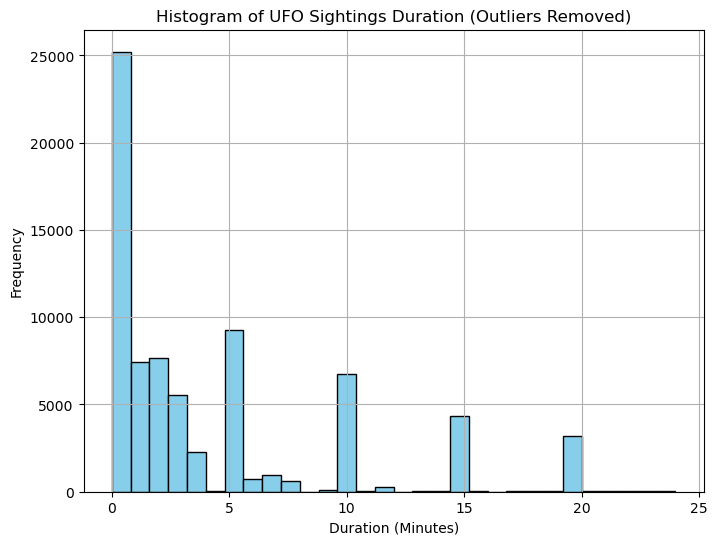

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the IQR
Q1 = ufo_data_cleaned['duration(minutes)'].quantile(0.25)
Q3 = ufo_data_cleaned['duration(minutes)'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds to filter outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to remove outliers
filtered_data = ufo_data_cleaned[(ufo_data_cleaned['duration(minutes)'] >= lower_bound) & 
                                 (ufo_data_cleaned['duration(minutes)'] <= upper_bound)]

# Plot the histogram without outliers
plt.figure(figsize=(8, 6))
plt.hist(filtered_data['duration(minutes)'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Duration (Minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of UFO Sightings Duration (Outliers Removed)')
plt.grid(True)
plt.show()



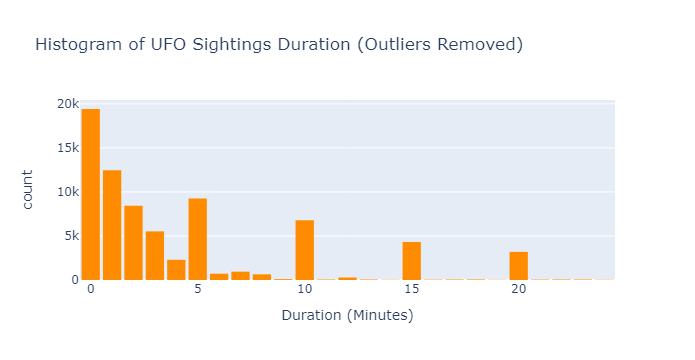

In [23]:
import plotly.express as px

# Calculate the IQR
Q1 = ufo_data_cleaned['duration(minutes)'].quantile(0.25)
Q3 = ufo_data_cleaned['duration(minutes)'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds to filter outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to remove outliers
filtered_data = ufo_data_cleaned[(ufo_data_cleaned['duration(minutes)'] >= lower_bound) & 
                                 (ufo_data_cleaned['duration(minutes)'] <= upper_bound)]

# Create histogram using Plotly
fig = px.histogram(filtered_data, x='duration(minutes)', nbins=30, 
                   labels={'duration(minutes)': 'Duration (Minutes)', 'count': 'Frequency'},
                   title='Histogram of UFO Sightings Duration (Outliers Removed)')
fig.update_traces(marker=dict(color='rgb(255, 140, 0)'))
fig.update_layout(bargap=0.1, bargroupgap=0.05)
fig.show()


## Movies

In [24]:
movies = pd.read_csv(r"C:\Users\12039\Documents\UFO_sightings\Movies.csv")
movies.head()

,Title,Year,Franchise,Unnamed: 3,Unnamed: 4,https://en.wikipedia.org/wiki/List_of_films_featuring_extraterrestrials
0,10 Cloverfield Lane,2016,Cloverfield[1],NaN,NaN,NaN
1,20 Million Miles to Earth,1957,[2],NaN,NaN,NaN
2,2001: A Space Odyssey,1968,Space Odyssey[3],NaN,NaN,NaN
3,2001: A Space Travesty,2000,[4],NaN,NaN,NaN
4,2010: The Year We Make Contact,1984,Space Odyssey[5],NaN,NaN,NaN


In [126]:
# Extract year from the 'date' column
bigfoot_sightings['year'] = bigfoot_sightings['date'].dt.year

# Group by 'state' and 'year' and get the counts
bf_counts = bigfoot_sightings.groupby(['state', 'year']).size().reset_index(name='count')

In [ ]:
#add to state_totals
state_totals = pd.read_csv('https://raw.githubusercontent.com/kflemming30/UFO_sightings/main/state_totals.csv')
